In [24]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn import neighbors

In [5]:
ROOT_PATH = "C:/Users/Oli/Desktop/Entrevistas/carebit insurtech/carebit_Exercise/Python/"

## Case 1: Classification

### Loading data

In [6]:
EX_PATH = os.path.join(ROOT_PATH, "Data/seeds_dataset.txt")
df = pd.read_csv(EX_PATH, sep='\t', header = None)
df.columns = ['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asym_coef', 'kernel_groove_length', 'class']

In [7]:
df.head()

,area,perimeter,compactness,kernel_length,kernel_width,asym_coef,kernel_groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


### Separate X and Y

In [8]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

### Split X and y into training and testing datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(168, 7)
(42, 7)
(168,)
(42,)


### Use the model of your choice to solve the multiclass problem: Fit the data and make the predictions.

First of all we want to know if the problem is balanced (more or less the same number of instances per class) or imbalanced.

In [10]:
counts = df[['class']].value_counts()
counts

class
3        70
2        70
1        70
dtype: int64

In this case we have a balanced dataset.

We will fit a random forest classifier to our data. We will tune the most important hyperparameters of the classifier by doing a cross validated randomized grid search, so the classifier will randomly select a combination of different hyperparameters n_iter times (in this case 100 combinations) and for each model fitted (for each combination of hyperparameters) we will apply a 5-fold cross validation in order to obtain a less biased estimator and reduce the chance of overfitting. 
The most important parameters to tune are:
- n_estimators: the number of trees in the random forest.
- max_features: the size of the random subsets of features to consider when splitting a node.
- max_depth: Maximum number of levels in a tree.
- min_samples_split: Minimum number of samples required to split a node.
- min_samples_leaf: Minimum number of samples required at each leaf node
- bootstrap: False if we use all the datapoints or True if random samples of our data are used.

In [11]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

The best parameters to apply to the classifier from fitting the random search are:

In [12]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

We select the best classifier applying the previous parameters to the random forest classifier:

In [13]:
rf_random_best = rf_random.best_estimator_

The vector corresponding to the prediction labels of the test (holdout) dataset is the following:

In [14]:
yhat = rf_random_best.predict(X_test)
yhat

array([2, 3, 1, 3, 1, 2, 3, 3, 3, 3, 2, 2, 1, 2, 3, 3, 1, 3, 2, 3, 1, 1,
       3, 2, 2, 1, 3, 1, 1, 3, 1, 3, 2, 2, 2, 3, 1, 1, 2, 2, 3, 2],
      dtype=int64)

### Evaluate the results using the metric of your choice.

Once the model is fitted with the training dataset and the predictions over the holdout dataset are done, is time to see how good or bad our model behaves, comparing the predictions to the real holdout dataset values.

In this case, because of the data is balanced our metric will be the accuracy, so the percentage of good predictions our model does.

In the confusion matrix below it can be seen that the classifier behaves really good on the holdout dataset, only failing in classify a datapoint as a class equal to 3 when it really belongs to class 1.

[[12  0  1]
 [ 0 14  0]
 [ 0  0 15]]


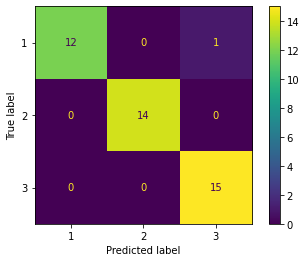

In [15]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, yhat))
metrics.plot_confusion_matrix(rf_random, X_test, y_test)

In [16]:
# overall accuracy
acc = rf_random_best.score(X_test,y_test)
acc

0.9761904761904762

The classifier has an accuracy of 97.6%, meaning that predict the correct class almost every time (almost 98  times out of 100).

## Case 2: Regression

### Loading data

In [17]:
from sklearn.datasets import load_boston
boston = load_boston()
df_x = pd.DataFrame(boston.data, columns = boston.feature_names)
df_y = pd.DataFrame(boston.target, columns = ['target'])
df = df_x.join(df_y)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Separate X and Y

In [18]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

### Split X and y into training and testing datasets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(379, 13)
(127, 13)
(379,)
(127,)


### Use the model of your choice to solve the regression problem: Fit the data and make the predictions.

Before fit the model we will scale all the predictors (that is substract to each value the mean and divide by the standard deviation of its variable) because, as in the following pair plot can be seen, the scale of the predictor variables are not the same. This way we will have all the predictor variables with the mean centered around 0 and with variance in the same order  and then all the variables will be equally important when the loss function will be computed.

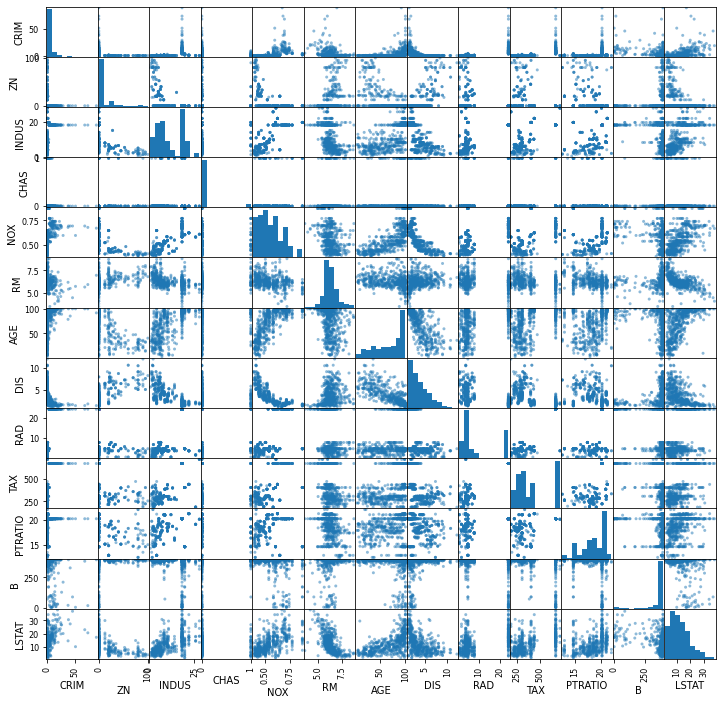

In [21]:
g = pd.plotting.scatter_matrix(X, figsize=(12,12), alpha = 0.5)
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

For tunning the only important parameter of the knn regressor (k, the number of closest datapoints or neighbors to each point) we will do a grid search as before, passing as a list the values from 2 to 30.
We will leave as default the values the rest of the KNeighborsRegressor function parameters, meaning that the type of distance to compute between points will be the euclidean distance.
For each one of the 28 values of the k parameter a 5-fols cross validation will be done.

In [25]:
params = {'n_neighbors':list(range(2,31))}

knn = neighbors.KNeighborsRegressor()

knn_model = GridSearchCV(knn, params, cv=5)
knn_model.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30]})

The best parameters to apply to the classifier from fitting the random search are:

In [26]:
knn_model.best_params_

{'n_neighbors': 9}

We select the best regressor applying the previous parameter to the knn regressor:

In [27]:
knn_model_best = knn_model.best_estimator_

The vector corresponding to the prediction labels of the test (holdout) dataset is the following:

In [28]:
yhat = knn_model_best.predict(X_test)
yhat

array([22.85555556, 24.74444444, 28.67777778, 17.4       , 35.7       ,
       21.44444444, 29.64444444, 16.25555556, 24.52222222, 12.41111111,
       24.46666667, 35.7       , 22.98888889, 23.56666667, 14.96666667,
       24.4       , 23.57777778, 22.88888889, 16.28888889, 18.4       ,
       13.75555556, 22.81111111, 21.11111111, 24.45555556, 11.28888889,
       16.93333333, 37.31111111, 23.95555556, 21.56666667,  9.85555556,
       27.98888889,  9.12222222, 17.54444444, 24.52222222, 37.31111111,
       22.42222222, 10.85555556, 40.33333333, 20.01111111, 15.53333333,
       23.96666667, 13.91111111, 22.07777778, 21.35555556, 20.85555556,
       34.68888889, 26.01111111, 16.82222222, 28.28888889, 17.07777778,
       19.96666667, 22.03333333, 16.27777778, 21.18888889, 22.43333333,
       22.23333333, 19.17777778, 18.25555556,  9.52222222, 20.85555556,
       22.        , 25.23333333, 21.52222222, 23.13333333, 19.31111111,
       23.3       , 27.95555556, 37.05555556, 24.08888889, 22.84

### Evaluate the results using the metric of your choice.

The best model selected shows an R squared of 69%, so with all the predictor variables we can explain almost the 70% of the variability of the response variable.

In [29]:
knn_model.best_score_

0.6938147518087505

### Visualization plot

To be able to plot a regression plot between the variables LSTAT and MEDV using knn regressor I have created 4 new regressors where the unique predictor variable is LSTAT and the only change between them is the k parameter.

In the scatter plot it is shown a negative relation between MEDV and LSTAT, so as LSTAT increase MEDV decrease.

The four regressors predictions follows the negative tendency, the difference between them is the spread of the predictions, as k increase more narrow (less overfitted) the predictions are, but more variance the residuals have.

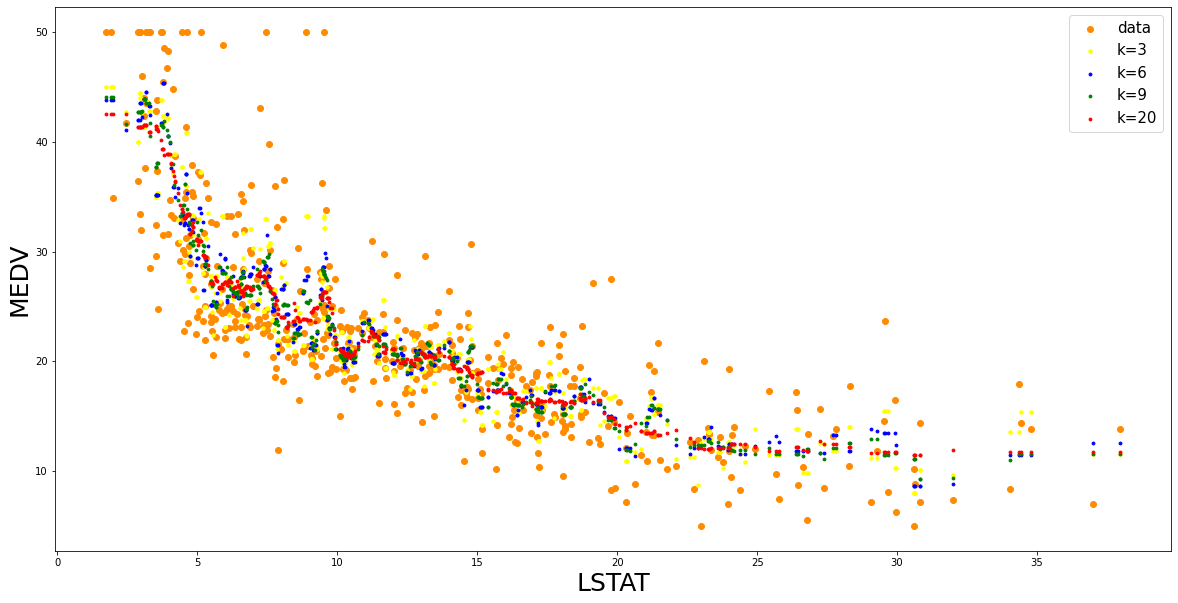

In [30]:
knn3 = neighbors.KNeighborsRegressor(n_neighbors=3)
knn3.fit(X[["LSTAT"]],y)

knn6 = neighbors.KNeighborsRegressor(n_neighbors=6)
knn6.fit(X[["LSTAT"]],y)

knn9 = neighbors.KNeighborsRegressor(n_neighbors=9)
knn9.fit(X[["LSTAT"]],y)

knn20 = neighbors.KNeighborsRegressor(n_neighbors=20)
knn20.fit(X[["LSTAT"]],y)

#plt.plot()
plt.figure(figsize=(20,10))
#fig, ax = plt.plot(figsize=(20, 10))
plt.scatter(X[["LSTAT"]], y, color='darkorange', label='data')
plt.scatter(X[["LSTAT"]], knn3.predict(X[["LSTAT"]]),color="yellow", s=12, label='k=3')
plt.scatter(X[["LSTAT"]], knn6.predict(X[["LSTAT"]]),color="blue", s=8, label='k=6')
plt.scatter(X[["LSTAT"]], knn9.predict(X[["LSTAT"]]),color="green", s=8, label='k=9')
plt.scatter(X[["LSTAT"]], knn20.predict(X[["LSTAT"]]),color="red", s=8, label='k=20')
plt.ylabel("MEDV", size = 25)
plt.xlabel("LSTAT", size = 25)
plt.legend(fontsize = 15)

## Questions

#### Which models did you chose for each problem? Why?

For the classification problem I have chosen a random forest classifier because this kind of ensemble models are well known to provide accurate results and are reasonably easy to be explained to others because the base model they came from (the decision trees) is very popular. Also this kind of models behaves good trying to find the non linear relationships of the data.

For the regression problem I have chosen a k nearest neighbour model because although it stands of for its simplicity and ease to be understood, it is powerfull enough to behaves as a good regressor when the dimensionality of the problem is nor too large.

#### Regarding the evaluation, which metrics are you using for the classification problem? Why are you using them and how do you interpret the results? And for the regression?

The metric I use for evaluate the classifier built in the classification problem is the accuracy. I use the accuracy and the confussion matrix, the first one because the problem is perfectly balanced and the second one to see specifically the correct/wrong predictions for each one of the classes and then see if there exists an specific class where the classifier behaves anormally or not.

I used this metric because is commonly used for regression problems and is a good measure of goodness of fit regarding the type of distance used to build the knn regressor, becasue in the end the objective is compare the predictions with the true values (squared). R squared informs us of the percentage of the data explained by our model using the formula:  
1 - (rss/tss), where:
- rss is the sum of the squared difference between predictions and actual values: sum((predict - actual) ^ 2)
- tss is the sum of the squared difference between the actual values and its mean : sum((actual - mean(actual)) ^ 2)

The only bad thing of this metric to evaluate regression models is that there is no penalization for the complexity of the model, so may be a better choice the adjusted R squared that divides the actual coefficient of determination by the number of parameters used in the model.

#### About the plot. How do you interpret the results? Which kind of relation is shown? Is it enough to take some conclusions or do we need to perform further analysis?

The scatter plot shows a negative relation between MEDV and LSTAT, so as LSTAT increase MEDV decrease. This relation exists and this conclusion is undeniable, but to build a model that predicts MEDV reasonably well we should include more variables that affect MEDV and may be that this negative relation between LSTAT and MEDV does not be true for all groups or ranges of the other variables. For example may be that MEDV decrease as LSTAT increase for low values of the RAD variable but can be that MEDV increase as LSTAT increase for gigher values of RAD.